In [1]:
# This is a project created to recognize the diseases from Eye Fundus images.

In [1]:
import pandas as pd
import ast

In [2]:
df = pd.read_csv(r"Dataset/full_df.csv")
df.head()

,ID,Patient Age,Patient Sex,Left-Fundus,Right-Fundus,Left-Diagnostic Keywords,Right-Diagnostic Keywords,N,D,G,C,A,H,M,O,filepath,labels,target,filename
0,0,69,Female,0_left.jpg,0_right.jpg,cataract,normal fundus,0,0,0,1,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",0_right.jpg
1,1,57,Male,1_left.jpg,1_right.jpg,normal fundus,normal fundus,1,0,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['N'],"[1, 0, 0, 0, 0, 0, 0, 0]",1_right.jpg
2,2,42,Male,2_left.jpg,2_right.jpg,laser spot，moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",2_right.jpg
3,4,53,Male,4_left.jpg,4_right.jpg,macular epiretinal membrane,mild nonproliferative retinopathy,0,1,0,0,0,0,0,1,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",4_right.jpg
4,5,50,Female,5_left.jpg,5_right.jpg,moderate non proliferative retinopathy,moderate non proliferative retinopathy,0,1,0,0,0,0,0,0,../input/ocular-disease-recognition-odir5k/ODI...,['D'],"[0, 1, 0, 0, 0, 0, 0, 0]",5_right.jpg


In [3]:
df_cleaned=df[["filename","labels"]].copy()

In [4]:
def extract_label(label_str):
    labels = ast.literal_eval(label_str)
    if len(labels) == 1:
        return labels[0]   # 'N', 'C', etc.
    else:
        return None      

In [5]:
df_cleaned["label"]= df_cleaned["labels"].apply(extract_label)

In [6]:
df_cleaned.drop(columns=["labels"],inplace=True)
df_cleaned.head()

,filename,label
0,0_right.jpg,N
1,1_right.jpg,N
2,2_right.jpg,D
3,4_right.jpg,D
4,5_right.jpg,D


label
N    2873
D    1608
O     708
C     293
G     284
A     266
M     232
H     128
Name: count, dtype: int64


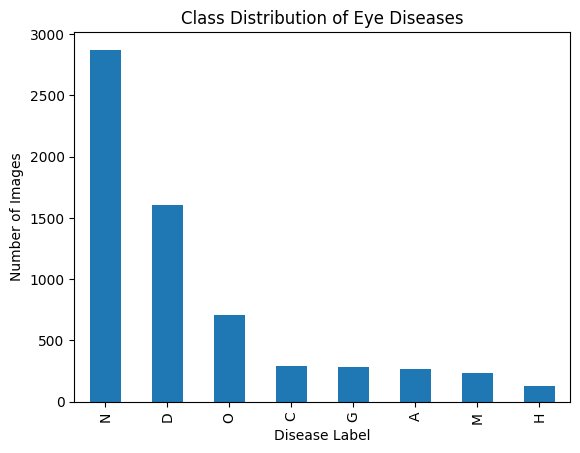

In [7]:
import matplotlib.pyplot as plt

class_counts = df_cleaned["label"].value_counts()
print(class_counts)

plt.figure()
class_counts.plot(kind="bar")
plt.xlabel("Disease Label")
plt.ylabel("Number of Images")
plt.title("Class Distribution of Eye Diseases")
plt.show()

In [7]:
IMG_DIR = "Dataset/Data_dir"
import os

In [8]:
df_cleaned["image_path"]=df_cleaned['filename'].apply(lambda x: os.path.join(IMG_DIR,x))

In [9]:
df_cleaned = df_cleaned[df_cleaned["image_path"].apply(os.path.exists)]

In [10]:
df_cleaned = df_cleaned.reset_index(drop=True)

In [11]:
df_cleaned.to_csv("main_dataset.csv",index=False)

Now lets do the pre processing steps to augment and enhance the image, by forming a dataset class

In [11]:
from torchvision import transforms

train_transforms = transforms.Compose([
    transforms.Resize((518, 518)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

test_transforms = transforms.Compose([
    transforms.Resize((518, 518)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


In [12]:
import cv2
import numpy as np

def enhance_image_opencv(img):
    lab = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)

    enhanced = cv2.merge((cl, a, b))
    enhanced = cv2.cvtColor(enhanced, cv2.COLOR_LAB2RGB)

    return enhanced


In [13]:
from torch.utils.data import Dataset
from PIL import Image
import pandas as pd
import os
import numpy as np

class EyeDataset(Dataset):
    def __init__(self, csv_file, image_dir, transform=None, enhance=False):
        self.data = pd.read_csv(csv_file)
        self.image_dir = image_dir
        self.transform = transform
        self.enhance = enhance

        # self.label_map = {
        #     "N": 0, "D": 1, "G": 2, "C": 3,
        #     "A": 4, "H": 5, "M": 6, "O": 7}
        self.label_map = {
                            "N": 0,   # Normal
                            "D": 1,   # Diabetic Retinopathy
                            "H": 2,   # Hypertensive Retinopathy
                            "A": 3,   # AMD
                            "G": 4,   # Others
                            "C": 4,   # Others
                            "M": 4,   # Others
                            "O": 4    # Others
                            }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path = os.path.join(
            self.image_dir,
            self.data.iloc[idx]["filename"]
        )

        # Load image
        image = Image.open(img_path).convert("RGB")

        # PIL → NumPy (for OpenCV)
        if self.enhance:
            image_np = np.array(image)
            image_np = enhance_image_opencv(image_np)
            image = Image.fromarray(image_np)

        label_str = self.data.iloc[idx]["label"]
        label = self.label_map[label_str]

        if self.transform:
            image = self.transform(image)

        return image, label


Split the dataset

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split


train_df, test_df = train_test_split(
    df_cleaned,
    test_size=0.2,
    stratify=df_cleaned["label"],
    random_state=42
)

# train_df.to_csv("train.csv", index=False)
# test_df.to_csv("test.csv", index=False)


In [15]:
train_dataset = EyeDataset(
    csv_file="train.csv",
    image_dir=IMG_DIR,
    transform=train_transforms,
    enhance=True  
)

test_dataset = EyeDataset(
    csv_file="test.csv",
    image_dir=IMG_DIR,
    transform=test_transforms,
    enhance=False 
)


In [16]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    train_dataset,
    batch_size=8,
    shuffle=True,
    num_workers=0,
    pin_memory=True
)

val_loader = DataLoader(
    test_dataset,
    batch_size=8,
    shuffle=False,
    num_workers=0,
    pin_memory=True
)


Phase 1 training resnet freezed and vit small gets the parameter updates during back propagation

In [17]:
import torch
import torch.nn as nn
import torchvision.models as models
import timm


class ResNet_DINOv2_Hybrid(nn.Module):
    def __init__(self, num_classes=5):
        super().__init__()

        # 1. ResNet50 backbone (FROZEN)
        resnet = models.resnet50(pretrained=True)
        for param in resnet.parameters():
            param.requires_grad = False

        # Remove avgpool and fc → keep spatial feature map
        self.resnet = nn.Sequential(*list(resnet.children())[:-2])
        # Output: [B, 2048, ~16, ~16] for 518x518 input

        # 2. Projection layer (2048 → 384)

        self.proj = nn.Linear(2048, 384)

        # 3. DINOv2 ViT-small with registers

        self.vit = timm.create_model(
            "vit_small_patch14_reg4_dinov2.lvd142m",
            pretrained=True,
            num_classes=0  # removes classification head
        )

        # 4. Final classifier
        self.classifier = nn.Linear(384, num_classes)

    def forward(self, x):
        # ResNet feature extraction
        feats = self.resnet(x)
        # [B, 2048, H, W] ≈ [B, 2048, 16, 16]

        B, C, H, W = feats.shape

        # Convert feature map to tokens
        tokens = feats.flatten(2).permute(0, 2, 1)
        # [B, H*W, 2048] → [B, 256, 2048]

        # Project to ViT embedding
        tokens = self.proj(tokens)
        # [B, 256, 384]


        # Class token
        cls_token = self.vit.cls_token.expand(B, -1, -1) # type: ignore

        # Register tokens (DINOv2 specific)
        reg_tokens = self.vit.reg_token.expand(B, -1, -1) # type: ignore

        # Concatenate: [CLS][REG][PATCH TOKENS]
        x = torch.cat((cls_token, reg_tokens, tokens), dim=1)

        # Add positional embeddings
        x = x + self.vit.pos_embed[:, : x.size(1), :] # type: ignore
        x = self.vit.pos_drop(x) # type: ignore

        # Transformer blocks
        for blk in self.vit.blocks: # type: ignore
            x = blk(x)

        x = self.vit.norm(x) # type: ignore

        # Take CLS token output
        vit_out = x[:, 0]

        # ---- Classification ----
        out = self.classifier(vit_out)
        return out



In [36]:
x = torch.randn(2, 3, 518, 518).cuda()
model = ResNet_DINOv2_Hybrid().cuda()
y = model(x)
print(y.shape)  # MUST be [2, 8]


torch.Size([2, 5])


In [18]:
import matplotlib.pyplot as plt

In [19]:
def accuracy_fn(outputs, labels):
    preds = torch.argmax(outputs, dim=1)
    correct = (preds == labels).sum().item()
    return correct / labels.size(0)


In [20]:
def train_phase(
    model,
    train_loader,
    val_loader,
    optimizer,
    chkpointname,
    scheduler,
    epochs=15,
    device="cuda"
):
    model.to(device)

    criterion = nn.CrossEntropyLoss()

    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    best_val_acc = 0.0

    for epoch in range(epochs):
        print(f"\nEpoch [{epoch+1}/{epochs}]")

        # ------------------ TRAIN ------------------
        model.train()
        running_loss = 0.0
        running_acc = 0.0

        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()

            outputs = model(images)
            loss = criterion(outputs, labels)

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            running_acc += accuracy_fn(outputs, labels)

        epoch_train_loss = running_loss / len(train_loader)
        epoch_train_acc = running_acc / len(train_loader)

        train_losses.append(epoch_train_loss)
        train_accs.append(epoch_train_acc)
        scheduler.step()

        # ------------------ VALIDATION ------------------
        model.eval()
        val_loss = 0.0
        val_acc = 0.0

        with torch.no_grad():
            for images, labels in val_loader:
                images = images.to(device)
                # labels = torch.tensor(labels, dtype=torch.long).to(device)
                labels = labels.to(device)


                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                val_acc += accuracy_fn(outputs, labels)

        epoch_val_loss = val_loss / len(val_loader)
        epoch_val_acc = val_acc / len(val_loader)

        val_losses.append(epoch_val_loss)
        val_accs.append(epoch_val_acc)

        print(
            f"Train Loss: {epoch_train_loss:.4f}, "
            f"Train Acc: {epoch_train_acc:.4f} | "
            f"Val Loss: {epoch_val_loss:.4f}, "
            f"Val Acc: {epoch_val_acc:.4f}"
        )

        # ------------------ SAVE BEST MODEL ------------------
        if epoch_val_acc > best_val_acc:
            best_val_acc = epoch_val_acc
            torch.save(
                {
                    "model_state": model.state_dict(),
                    "epoch": epoch + 1,
                    "val_acc": best_val_acc
                },
                chkpointname
            )
            print("✅ Best model saved")

    return train_losses, train_accs, val_losses, val_accs


In [21]:
def plot_metrics(train_losses, val_losses, train_accs, val_accs):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))

    # Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.plot(epochs, val_losses, label="Val Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.title("Loss Curve")

    # Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accs, label="Train Acc")
    plt.plot(epochs, val_accs, label="Val Acc")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.title("Accuracy Curve")

    plt.tight_layout()
    plt.show()


In [30]:
sample_img, sample_label = train_dataset[0]
print(sample_label, type(sample_label))


1 <class 'int'>


In [38]:
model = ResNet_DINOv2_Hybrid(num_classes=5)

In [39]:
optimizer_phase1 = torch.optim.AdamW(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=3e-4
    )

In [40]:
scheduler_phase1 = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer_phase1,
    T_max=15,      # same as epochs
    eta_min=1e-6
)


Epoch [1/15]
Train Loss: 1.3000, Train Acc: 0.4336 | Val Loss: 1.1991, Val Acc: 0.4864
✅ Best model saved

Epoch [2/15]
Train Loss: 1.1935, Train Acc: 0.4924 | Val Loss: 1.2327, Val Acc: 0.4917
✅ Best model saved

Epoch [3/15]
Train Loss: 1.1380, Train Acc: 0.5150 | Val Loss: 1.1104, Val Acc: 0.5326
✅ Best model saved

Epoch [4/15]
Train Loss: 1.0765, Train Acc: 0.5486 | Val Loss: 1.1408, Val Acc: 0.5318

Epoch [5/15]
Train Loss: 1.0659, Train Acc: 0.5633 | Val Loss: 1.1309, Val Acc: 0.5348
✅ Best model saved

Epoch [6/15]
Train Loss: 1.0319, Train Acc: 0.5850 | Val Loss: 1.1112, Val Acc: 0.5606
✅ Best model saved

Epoch [7/15]
Train Loss: 0.9998, Train Acc: 0.5918 | Val Loss: 1.0934, Val Acc: 0.5473

Epoch [8/15]
Train Loss: 0.9865, Train Acc: 0.6029 | Val Loss: 1.1127, Val Acc: 0.5706
✅ Best model saved

Epoch [9/15]
Train Loss: 0.9697, Train Acc: 0.6109 | Val Loss: 1.1101, Val Acc: 0.5638

Epoch [10/15]
Train Loss: 0.9300, Train Acc: 0.6287 | Val Loss: 1.1077, Val Acc: 0.5738
✅ Bes

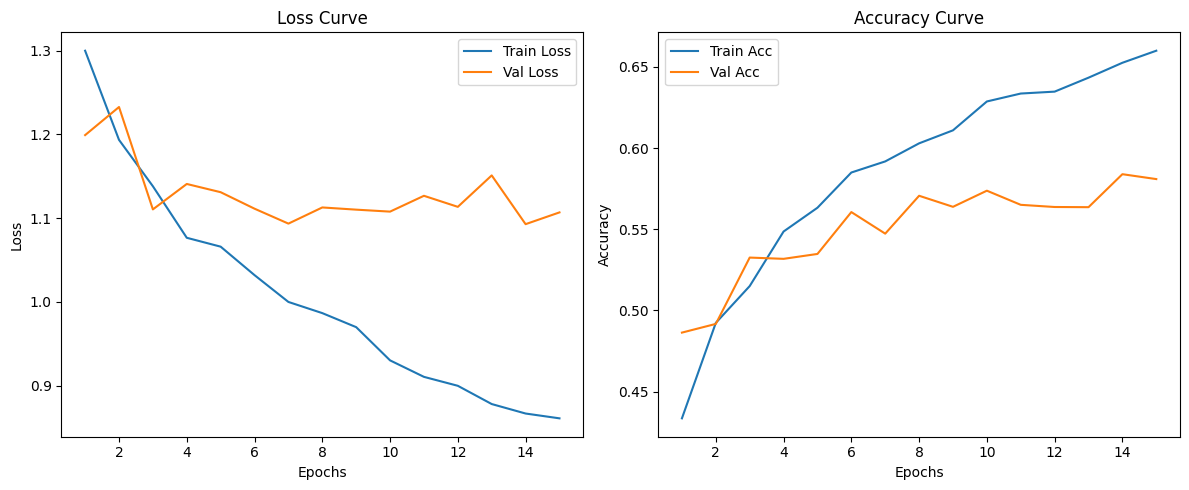

In [41]:
train_losses, train_accs, val_losses, val_accs = train_phase(
    model,
    train_loader,
    val_loader,
    optimizer=optimizer_phase1,
    chkpointname="model_1_phase1_training_partial_best.pth",
    scheduler=scheduler_phase1,
    epochs=15,
    device="cuda"
)

plot_metrics(train_losses, val_losses, train_accs, val_accs)


Phase 2 starts

In [23]:
model_2 = ResNet_DINOv2_Hybrid(num_classes=5) 

In [24]:
ckpt = torch.load(
    "model_1_phase1_training_partial_best.pth",
    map_location="cuda"
)

model_2.load_state_dict(ckpt["model_state"])
model_2.to("cuda")

ResNet_DINOv2_Hybrid(
  (resnet): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (downsample): Sequential(
          (0):

In [25]:
# Freeze ResNet completely
for p in model_2.resnet.parameters():
    p.requires_grad = False

# Unfreeze ViT
for p in model_2.vit.parameters():
    p.requires_grad = True

# Ensure projection + classifier are trainable
for p in model_2.proj.parameters():
    p.requires_grad = True

for p in model_2.classifier.parameters():
    p.requires_grad = True


In [26]:
optimizer_phase2 = torch.optim.AdamW(
    [
        {"params": model_2.vit.parameters(), "lr": 1e-4},
        {"params": model_2.proj.parameters(), "lr": 3e-4},
        {"params": model_2.classifier.parameters(), "lr": 3e-4},
    ],
    weight_decay=1e-4
)


In [27]:
scheduler_phase2 = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer_phase2,
    T_max=15,      # same as epochs
    eta_min=1e-6
)

In [28]:
sum(p.numel() for p in model_2.vit.parameters() if p.requires_grad)

22057344


Epoch [1/15]
Train Loss: 0.9129, Train Acc: 0.6373 | Val Loss: 1.0409, Val Acc: 0.5575
✅ Best model saved

Epoch [2/15]
Train Loss: 0.8961, Train Acc: 0.6375 | Val Loss: 1.0782, Val Acc: 0.5762
✅ Best model saved

Epoch [3/15]
Train Loss: 0.8881, Train Acc: 0.6484 | Val Loss: 1.1628, Val Acc: 0.5589

Epoch [4/15]
Train Loss: 0.8722, Train Acc: 0.6490 | Val Loss: 1.0964, Val Acc: 0.5744

Epoch [5/15]
Train Loss: 0.8604, Train Acc: 0.6572 | Val Loss: 1.0674, Val Acc: 0.5833
✅ Best model saved

Epoch [6/15]
Train Loss: 0.8449, Train Acc: 0.6629 | Val Loss: 1.0875, Val Acc: 0.5769

Epoch [7/15]
Train Loss: 0.8227, Train Acc: 0.6697 | Val Loss: 1.0469, Val Acc: 0.6004
✅ Best model saved

Epoch [8/15]
Train Loss: 0.8161, Train Acc: 0.6711 | Val Loss: 1.0673, Val Acc: 0.5989

Epoch [9/15]
Train Loss: 0.7816, Train Acc: 0.6887 | Val Loss: 1.1055, Val Acc: 0.5865

Epoch [10/15]
Train Loss: 0.7675, Train Acc: 0.6912 | Val Loss: 1.1167, Val Acc: 0.5856

Epoch [11/15]
Train Loss: 0.7639, Train Ac

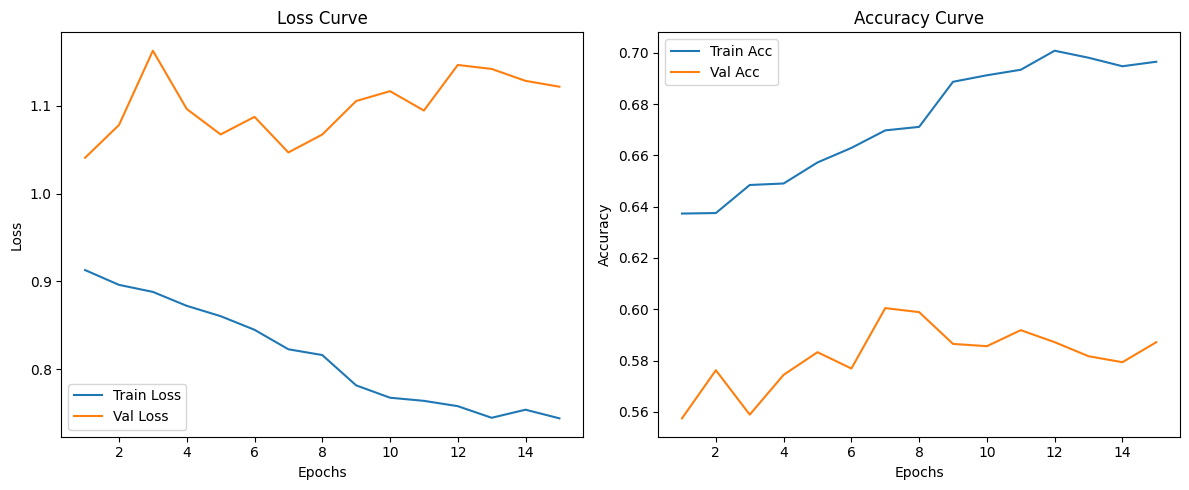

In [30]:
train_losses, train_accs, val_losses, val_accs = train_phase(
    model_2,
    train_loader,
    val_loader,
    optimizer=optimizer_phase2,
    chkpointname="model_1_phase2_training_partial_best.pth",
    scheduler=scheduler_phase2,
    epochs=15,
    device="cuda")

plot_metrics(train_losses, val_losses, train_accs, val_accs)

Now lets start phase 3 by unfreezing the layer 4 of the resnet to allow partial learning

In [31]:
model_3 = ResNet_DINOv2_Hybrid(num_classes=5) 

In [32]:
checkpoint = torch.load("model_1_phase2_training_partial_best.pth")
model_3.load_state_dict(checkpoint["model_state"])


<All keys matched successfully>

In [33]:
for p in model_3.parameters():
    p.requires_grad = False


vit params openend

In [34]:
for p in model_3.vit.parameters():
    p.requires_grad = True

for p in model_3.proj.parameters():
    p.requires_grad = True

for p in model_3.classifier.parameters():
    p.requires_grad = True


Now lets focus on releasing the params of resnet

In [35]:
for name, module in model_3.resnet.named_children():
    if name in ["layer3", "layer4"]:
        for p in module.parameters():
            p.requires_grad = True


In [36]:
optimizer_phase3 = torch.optim.AdamW(
    [
        # ResNet (very small LR)
        {
            "params": [
                p for n, p in model_3.resnet.named_parameters()
                if p.requires_grad
            ],
            "lr": 1e-5
        },

        # ViT backbone
        {
            "params": model_3.vit.parameters(),
            "lr": 5e-5
        },

        # Projection + classifier
        {
            "params": list(model_3.proj.parameters()) +
                      list(model_3.classifier.parameters()),
            "lr": 1e-4
        },
    ],
    weight_decay=1e-4
)


In [37]:
scheduler_phase3 = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer_phase3,
    T_max=15,      # same as epochs
    eta_min=1e-6
)

In [38]:
sum(p.numel() for p in model_3.parameters() if p.requires_grad)


22846085


Epoch [1/15]
Train Loss: 0.8163, Train Acc: 0.6705 | Val Loss: 1.1144, Val Acc: 0.5786
✅ Best model saved

Epoch [2/15]
Train Loss: 0.7932, Train Acc: 0.6799 | Val Loss: 1.1008, Val Acc: 0.5848
✅ Best model saved

Epoch [3/15]
Train Loss: 0.7848, Train Acc: 0.6842 | Val Loss: 1.0845, Val Acc: 0.5692

Epoch [4/15]
Train Loss: 0.7750, Train Acc: 0.6900 | Val Loss: 1.0858, Val Acc: 0.5926
✅ Best model saved

Epoch [5/15]
Train Loss: 0.7678, Train Acc: 0.6936 | Val Loss: 1.1275, Val Acc: 0.5754

Epoch [6/15]
Train Loss: 0.7606, Train Acc: 0.7020 | Val Loss: 1.1344, Val Acc: 0.5731

Epoch [7/15]
Train Loss: 0.7490, Train Acc: 0.6979 | Val Loss: 1.1266, Val Acc: 0.5715

Epoch [8/15]
Train Loss: 0.7392, Train Acc: 0.6980 | Val Loss: 1.1130, Val Acc: 0.5887

Epoch [9/15]
Train Loss: 0.7347, Train Acc: 0.7090 | Val Loss: 1.1168, Val Acc: 0.5786

Epoch [10/15]
Train Loss: 0.7194, Train Acc: 0.7100 | Val Loss: 1.1176, Val Acc: 0.5934
✅ Best model saved

Epoch [11/15]
Train Loss: 0.7251, Train Ac

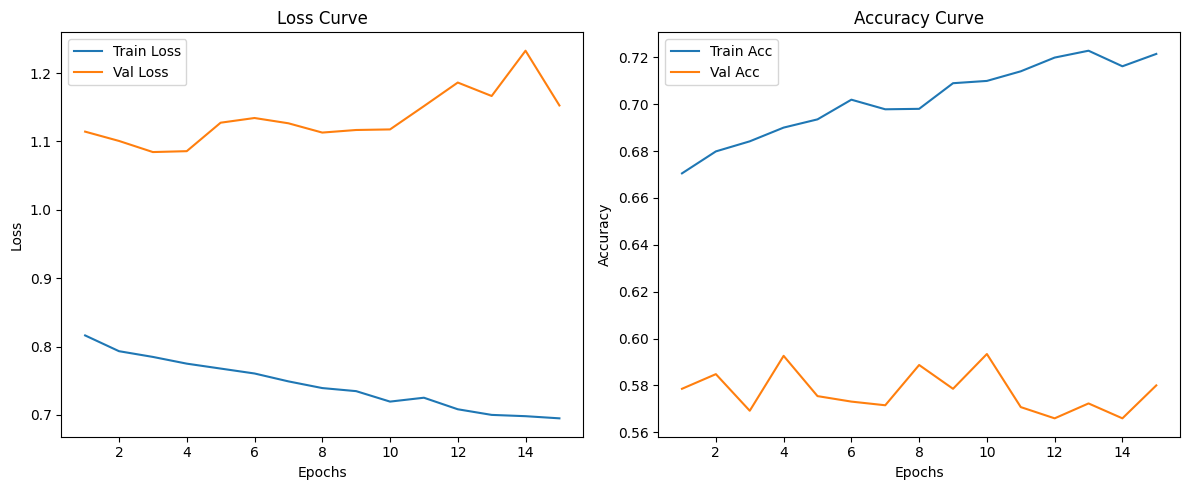

In [39]:
train_losses, train_accs, val_losses, val_accs = train_phase(
    model_3,
    train_loader,
    val_loader,
    optimizer=optimizer_phase3,
    chkpointname="model_1_phase3_training_partial_best.pth",
    scheduler=scheduler_phase3,
    epochs=15,
    device="cuda")

plot_metrics(train_losses, val_losses, train_accs, val_accs)